In [1]:
# Import Packages

import tensorflow as tf
import numpy as np
import pandas as pd
import re # regular expressions

# For Data Preparation
import nltk.data
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

from collections import Counter


# For Word Embedding
import gensim
import gensim.models as g
from gensim.models import Word2Vec
from gensim.models import Phrases

import logging
#import visword2vec as vv

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
#from matplotlib import pyplot

from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt




# For LSTM Model
from tensorflow.contrib import rnn
import pprint

pp = pprint.PrettyPrinter(indent=4)
sess = tf.InteractiveSession()
tf.set_random_seed(777)  # reproducibility

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/eunbeejang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eunbeejang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Preparation

In [2]:
# Data Processing

'''
#Read File
with open('FILE NAME', 'r') as f:
    bias_data = f.read()
'''

# Names for the columns (Header)
#cols = ['sentence', 'bias', 'sex', 'age', 'occupation', 'citizenship']

# Load the data from a CSV (returns type(dataframe))
bias_data = pd.read_csv('./scrapeBIG2.csv', sep=',',  encoding='latin-1') # encoding='latin-1', names=cols, header=None,
print("Data loaded")


# Randomize data
bias_data = bias_data.reindex(np.random.permutation(bias_data.index))

# Replace NAN with Zero(0)
bias_data.fillna(0, inplace=True)



print(len(bias_data))


"""
# Accessing the data
bias_data.value
bias_data[rows:cols]

# Basic Stats about the data
bias_data.describe()
bias_data.count
"""

Data loaded
1614


'\n# Accessing the data\nbias_data.value\nbias_data[rows:cols]\n\n# Basic Stats about the data\nbias_data.describe()\nbias_data.count\n'

In [3]:



bias_data[:10]




,Sentence,Bias,Sex,Age,Occupation,Citizenship
342,Leadership attributions in performance evaluat...,0,0.0,0.0,0.0,0.0
1526,But the messages they get from their environme...,1,0.0,0.0,0.0,0.0
1409,Overscheduled parents may think they don't hav...,1,0.0,0.0,0.0,0.0
522,That is why it is so important that men who ha...,0,0.0,0.0,0.0,0.0
1354,Once money issues are sorted and the destinati...,1,0.0,0.0,0.0,0.0
85,"Duncan said she had already asked Ian Stewart,...",0,0.0,0.0,0.0,0.0
1114,Your profile spells out exactly what you are a...,1,0.0,0.0,0.0,0.0
955,While it's hard to move on during the initial ...,0,0.0,0.0,0.0,0.0
1282,"I don't care what the body parts are, as long ...",0,0.0,0.0,0.0,0.0
1290,"What matters, she said, was not whether men da...",0,0.0,0.0,0.0,0.0


In [4]:
sentence = bias_data['Sentence']
label = bias_data['Bias']

print(type(sentence))
print(type(label))
#weight = bias_data['Weight']

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [5]:
#print(sentence)
#print(label)
print(sentence[0])


Imagine walking down the street and seeing advertising screens change their content based on how you walk, how you talk, or even the shape of your chest.


In [6]:
# Convert a sentence into a list of words

def sentence_to_wordlist(sentence, remove_stopwords=False):
    # 1. Remove non-letters
    sentence_text = re.sub(r'[^\w\s]','', sentence)
    # 2. Convert words to lower case and split them
    words = sentence_text.lower().split()
    # 3. Stemming
    words = [stemmer.stem(w) for w in words] 
    # 4. Lemmatizing
    words = [lemmatizer.lemmatize(word) for word in words]
    # 3. Return a list of words
    return(words)

In [7]:
sentence_to_wordlist(sentence[0])

['imagin',
 'walk',
 'down',
 'the',
 'street',
 'and',
 'see',
 'advertis',
 'screen',
 'chang',
 'their',
 'content',
 'base',
 'on',
 'how',
 'you',
 'walk',
 'how',
 'you',
 'talk',
 'or',
 'even',
 'the',
 'shape',
 'of',
 'your',
 'chest']

In [8]:
# List of sentences where each sentence is a list of words
def data_to_sentences(data, tokenizer, remove_stopwords=False ):
    try:
        # 1. Use the NLTK tokenizer to split the text into sentences
        raw_sentences = tokenizer.tokenize(data.strip())
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call sentence_to_wordlist to get a list of words
                sentences.append(sentence_to_wordlist(raw_sentence))
        # 3. Return the list of sentences (each sentence is a list of words, so this returns a list of lists)
        len(sentences)
        #print('GOOD')
        return sentences
    except:
        print('ERROR :', data)

In [9]:
def list_of_sentences(data):
    sentences = []
    for i in data:
        sentences.append(sentence_to_wordlist(i))
    return sentences

In [10]:
print(type(sentence))

<class 'pandas.core.series.Series'>


In [ ]:
#sentence = bias_data['sentence'].tolist()

sentences = []

for i in range(len(sentence)):
    # Replace all the numbers with ### -- this will remove all the numbers from the sentence
    #data = re.sub("\d", "####", sentence[i]) 
    # data = sentence[i].replace(/[0-9]+/g, '###')
    sentences += data_to_sentences(sentence[i], tokenizer)

print("There are " + str(len(sentences)) + " sentences in the corpus of bias_data.")
              
# Accessing each sentences
# sentences[index]

In [14]:
sentences = list_of_sentences(bias_data['Sentence'])
labels = bias_data['Bias'].tolist()

print(len(labels))
print(len(sentence))
print(len(sentences))
print(len(bias_data))
sentences

1614
1614
1614
1614


[['leadership', 'attribut', 'in', 'perform', 'evalu', 'are', 'power'],
 ['but',
  'the',
  'messag',
  'they',
  'get',
  'from',
  'their',
  'environ',
  'are',
  'import',
  'and',
  'so',
  'is',
  'the',
  'chanc',
  'to',
  'play',
  'with',
  'toy',
  'and',
  'with',
  'other',
  'child',
  'in',
  'way',
  'that',
  'dont',
  'box',
  'them',
  'in',
  'too',
  'tight'],
 ['overschedul',
  'parent',
  'may',
  'think',
  'they',
  'dont',
  'have',
  'time',
  'for',
  'play',
  'with',
  'doll',
  'or',
  'build',
  'with',
  'block'],
 ['that',
  'is',
  'whi',
  'it',
  'is',
  'so',
  'import',
  'that',
  'men',
  'who',
  'have',
  'the',
  'opportun',
  'to',
  'open',
  'these',
  'door',
  'to',
  'more',
  'woman',
  'take',
  'it'],
 ['onc',
  'money',
  'issu',
  'are',
  'sort',
  'and',
  'the',
  'destin',
  'is',
  'chosen',
  'the',
  'biggest',
  'obstacl',
  'are',
  'the',
  'challeng',
  'of',
  'who',
  'sleep',
  'in',
  'which',
  'room',
  'and',
  'wh

# Word Embedding

In [15]:
# Create Word Vectors

# train model
model = Word2Vec(sentences, min_count=1)

# Calling init_sims will make the model will be better for memory if we don't want to train the model over and over again
model.init_sims(replace=True)

# Summarize the loaded model
print(model)

# Summarize vocabulary
words = list(model.wv.vocab)
print(len(words))






# save model
model.save('model.bin')

# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

# access vector for one word
#print(model['sentence'])



Word2Vec(vocab=3979, size=100, alpha=0.025)
3979
Word2Vec(vocab=3979, size=100, alpha=0.025)


/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


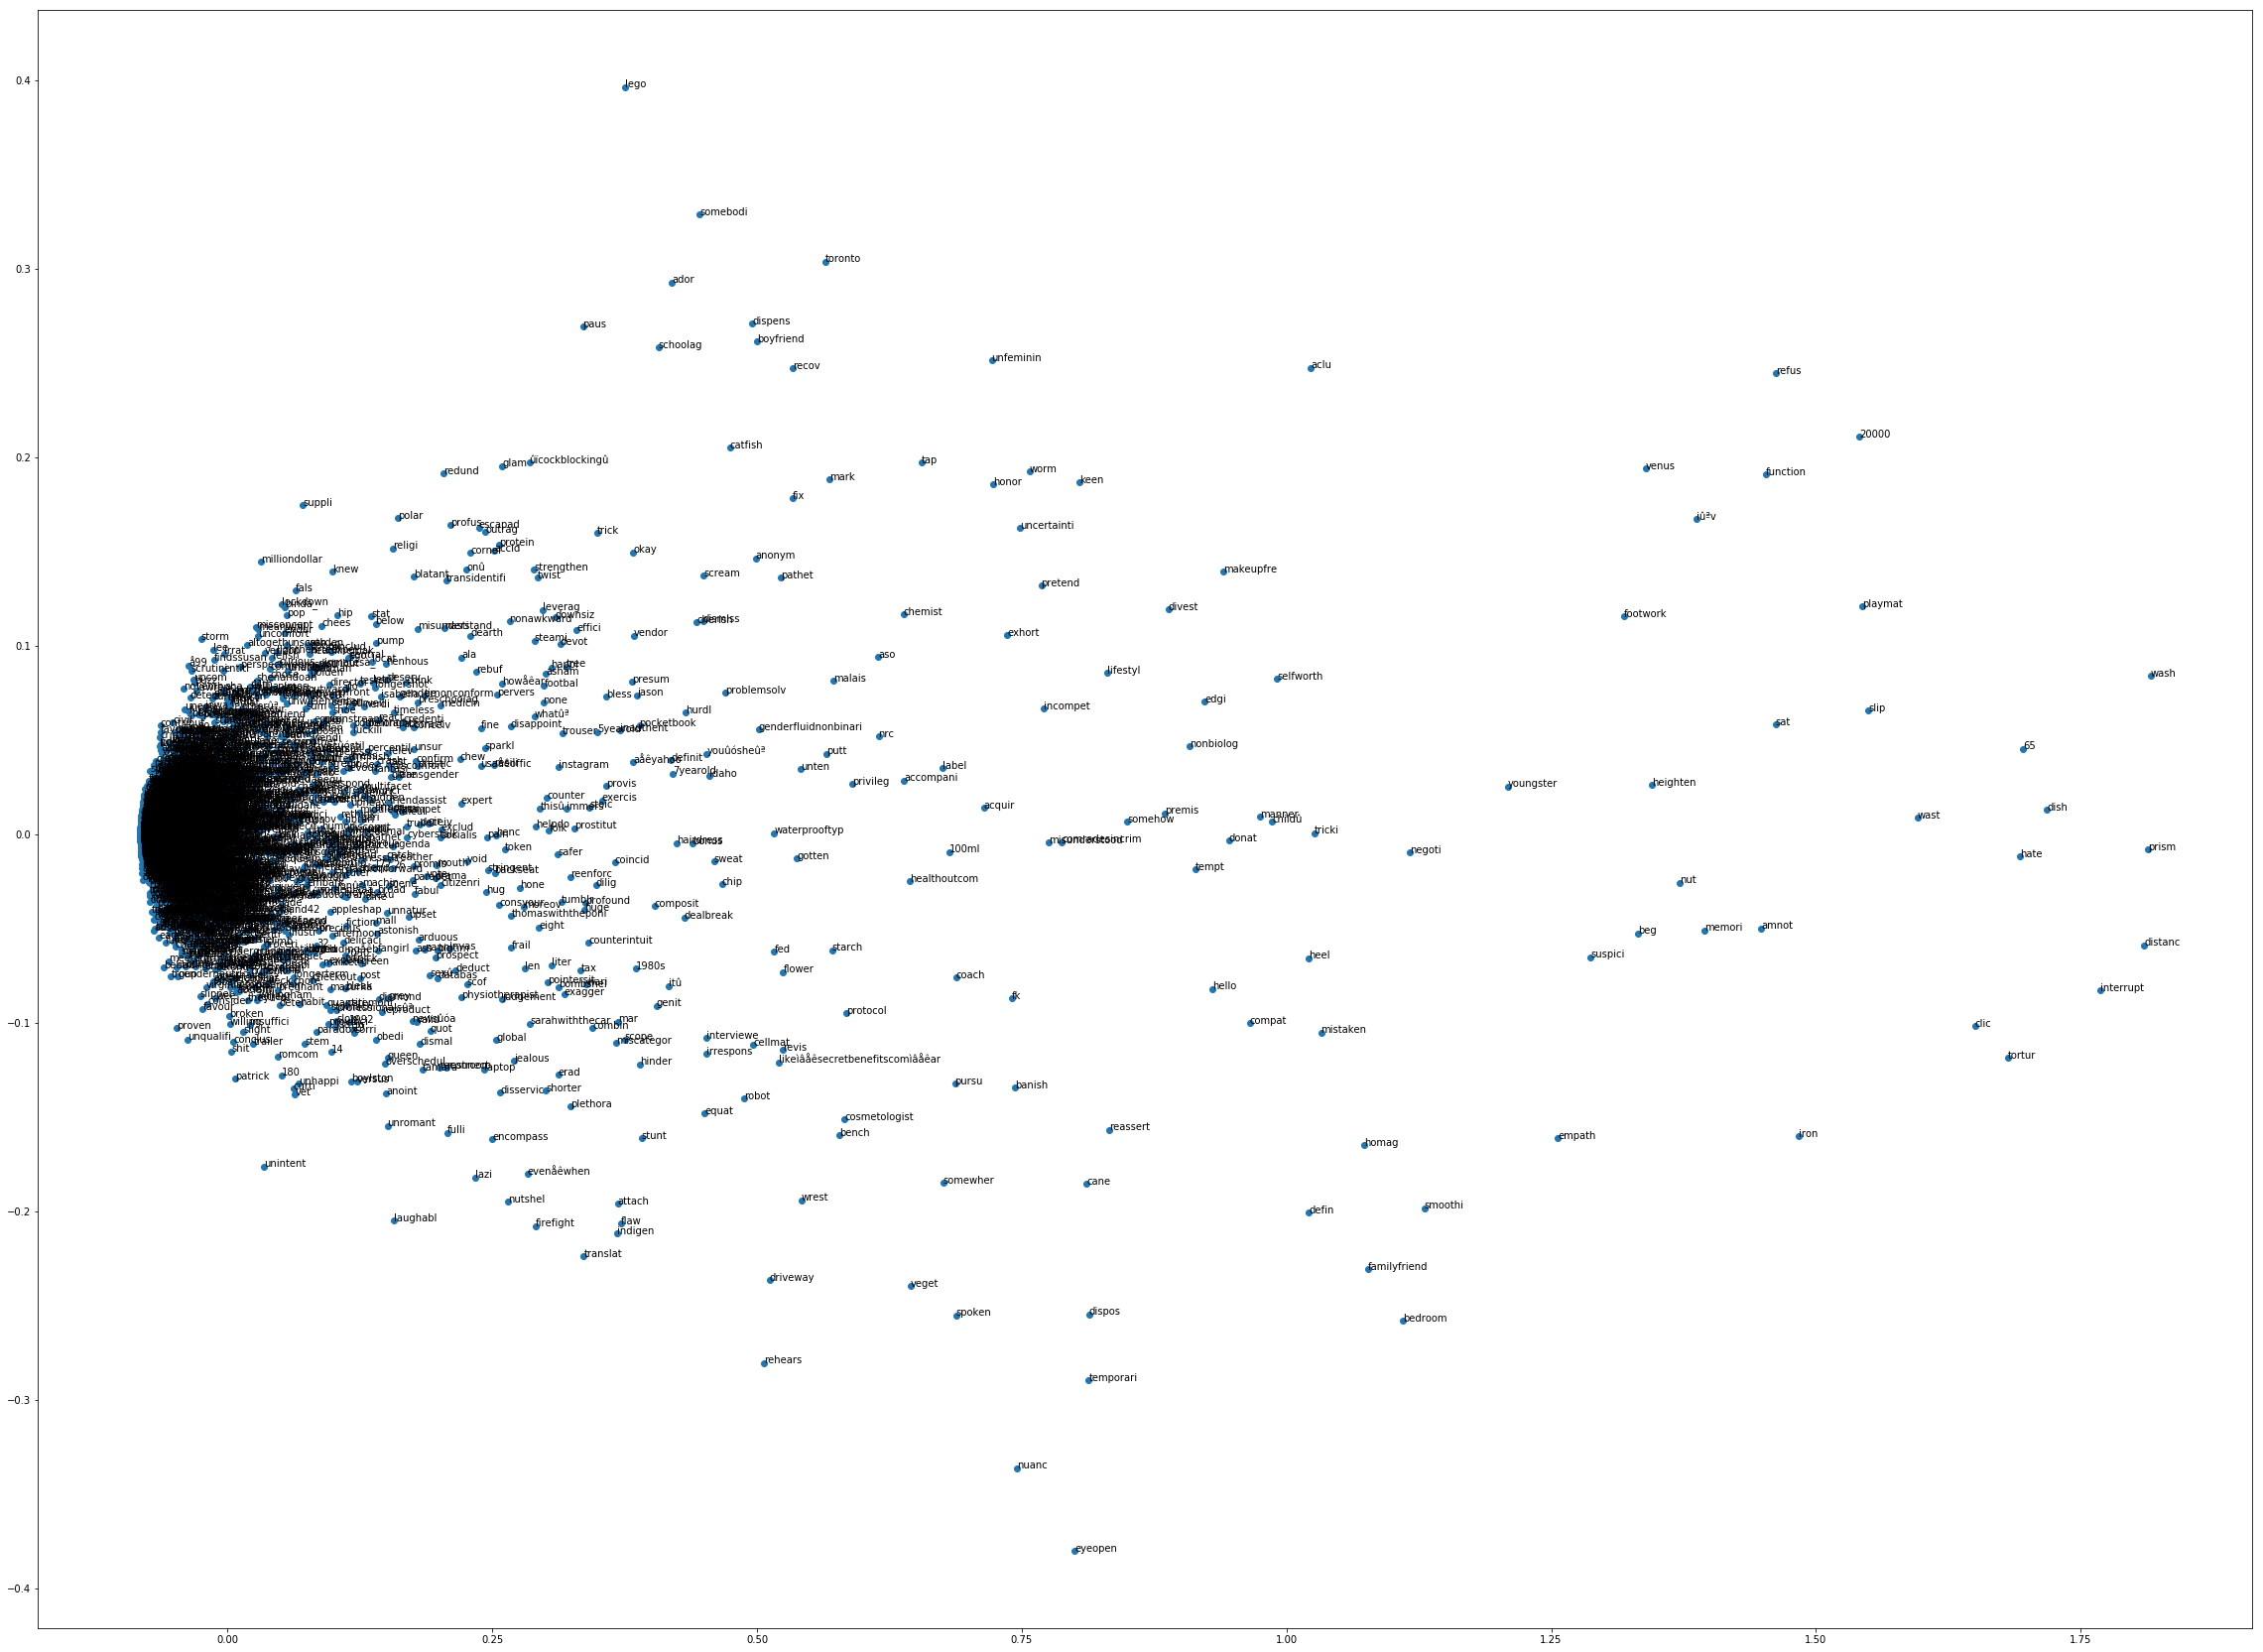

In [16]:

# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(40,30))
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()


In [17]:
# Visualize word2vec with t-SNE

# Deal with font errors
mpl.rcParams['axes.unicode_minus'] = False

this_model = g.Doc2Vec.load('model.bin')
this_vocab = list(this_model.wv.vocab)
X = this_model[this_vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components = 2)

# Vector only 100 words
X_tsne = tsne.fit_transform(X[:50,:])

df = pd.DataFrame(X_tsne, index=this_vocab[:50], columns=['x','y'])
df.shape

df.head(10)

/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


3979
[ 0.08717908  0.04447128  0.0831043  -0.34195453  0.02818398  0.08929494
  0.11279775  0.07031235  0.14903288 -0.04313724]


,x,y
leadership,98.436432,-71.123444
attribut,-12.264198,-118.746033
in,-25.359470,-17.536062
perform,74.401001,-39.153801
evalu,54.490524,81.773048
are,1.152134,7.936991
power,63.858582,46.535713
but,41.633671,-2.834734
the,9.344908,-19.878998
messag,-69.862045,50.112854


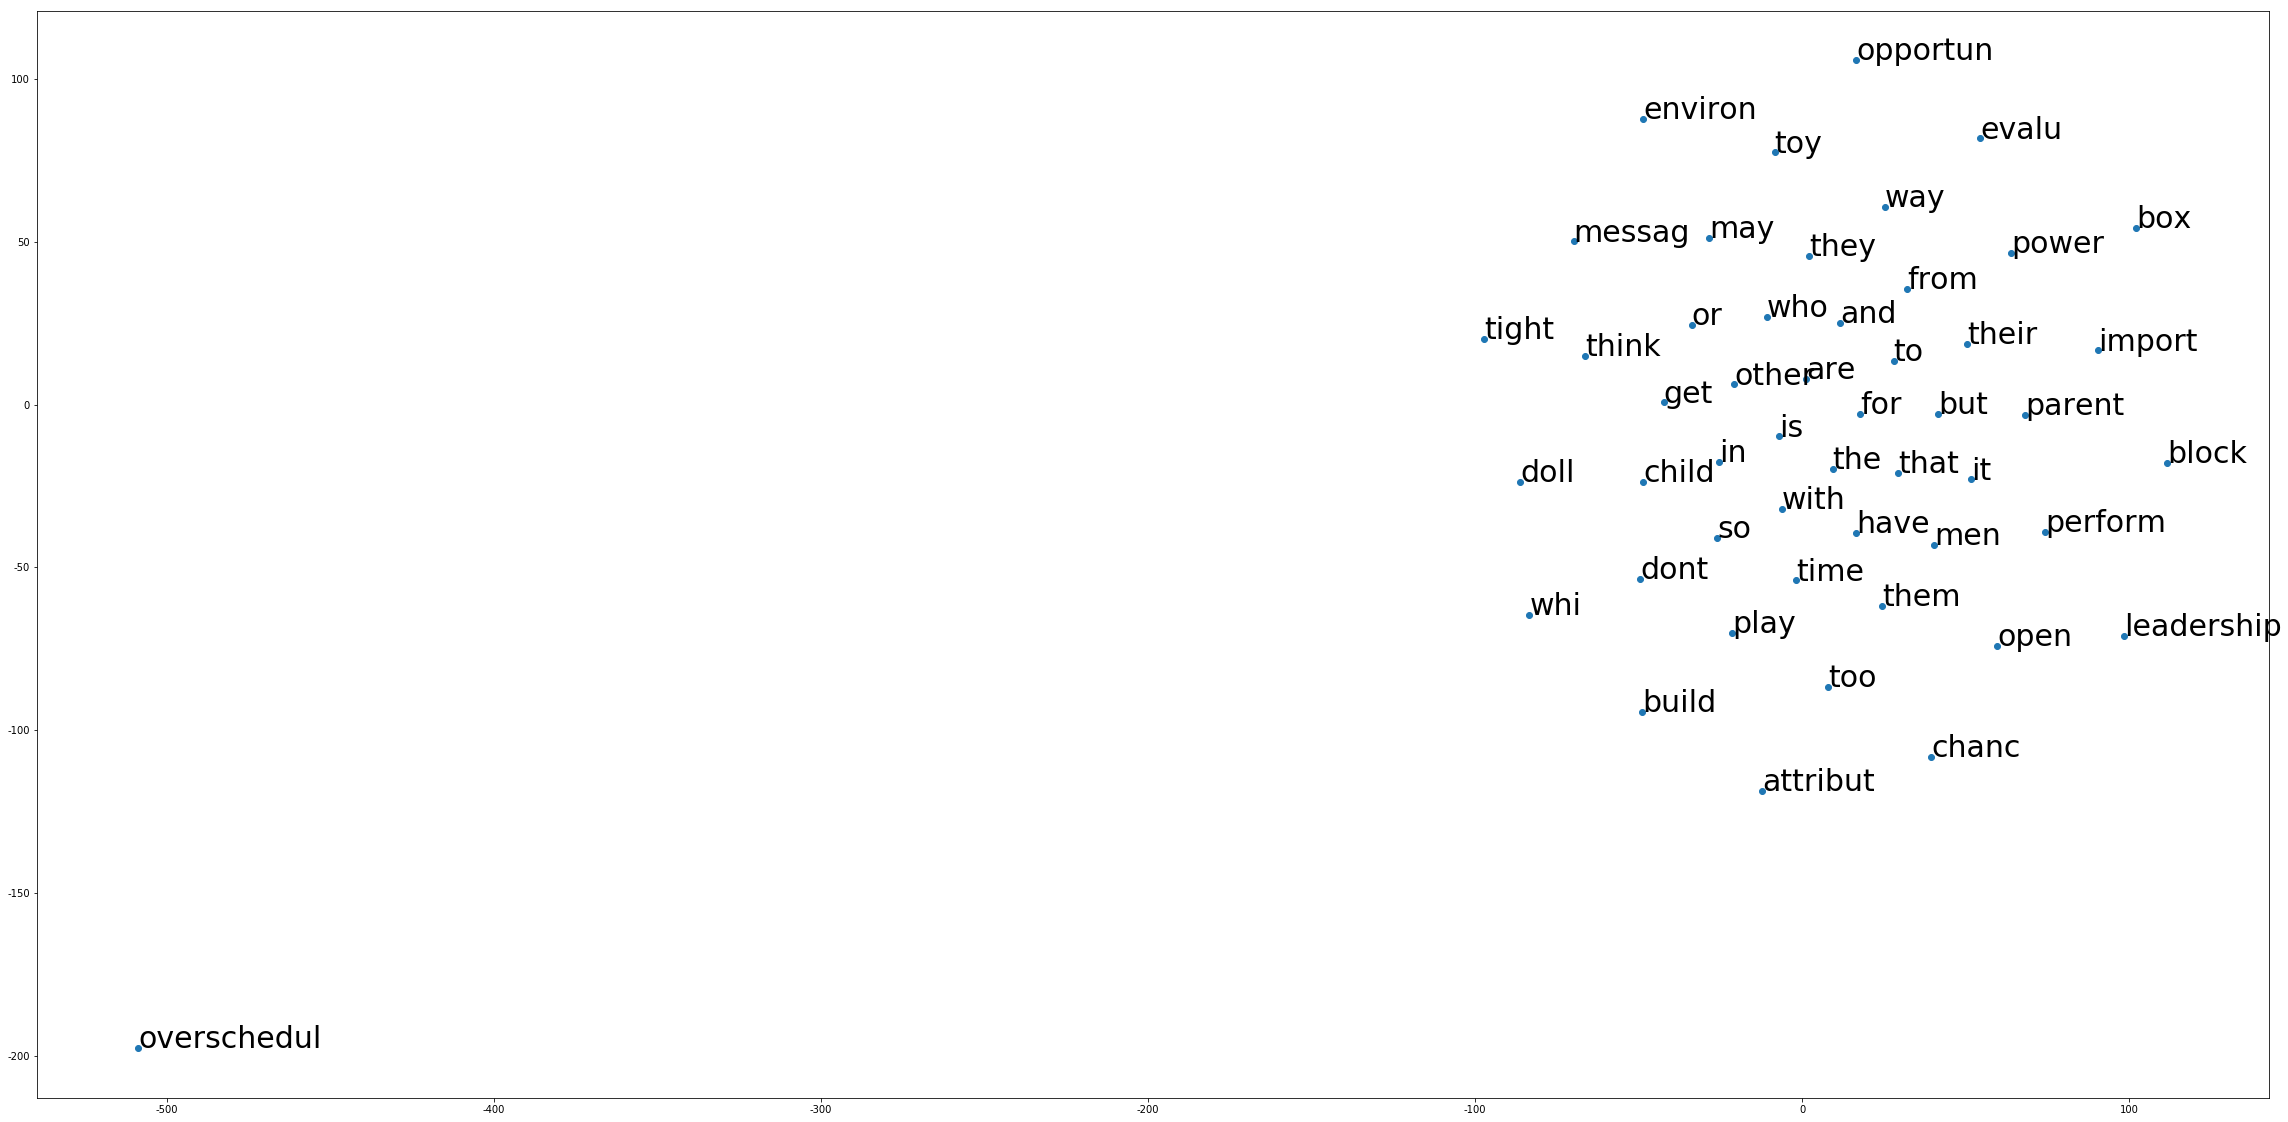

In [18]:
# Plot using TSNE
fig = plt.figure()
fig.set_size_inches(40,20)
ax = fig.add_subplot(1,1,1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

In [41]:
model.wv.most_similar("leadership")


[('famili', 0.9982816576957703),
 ('back', 0.9982362389564514),
 ('last', 0.998224675655365),
 ('some', 0.9981800317764282),
 ('still', 0.9981689453125),
 ('up', 0.9981685876846313),
 ('be', 0.9981648325920105),
 ('use', 0.9981614351272583),
 ('been', 0.9981578588485718),
 ('lot', 0.9981560707092285)]

In [42]:
###################################### DON'T NEED THIS
###################################### IGNORE THIS CELL
# sentence_index = (example) sentence[0]

def sentence_to_vector(sentence_index):
    each_sentence = sentence_to_wordlist(sentence_index)
    each_sentence_vector = []
    for word in each_sentence:
        ##### ASK ANDRE:  Should the sentence be a list or a numpy array??
        each_sentence_vector.append([model[word]])
    each_sentence_vector = np.asarray(each_sentence_vector)
    #print(type(each_sentence_vector)) # Check the type of the sentence vector
    #print(each_sentence_vector.shape) # Check the shape of the sentence vector
    return each_sentence_vector

In [43]:
sentence_to_vector(sentence[0]).shape


/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


(27, 1, 100)

In [44]:
print(type(words))

<class 'list'>


In [45]:
# Build dictionary & inv_vocab
def create_vocab(data_collect, max_vocab):
    """ Create a dictionary of words to int, and the reverse

    You'll want to save this, required for model restore
    """
    # Get raw data
    # x_list = [data.x for data in data_collect.values()]
    x_list = data_collect
    sample_count = sum([len(x) for x in x_list])
    words = []
    for data in x_list:
      words.extend([data])
   # words.extend([self.eos_tag] * sample_count) # silly hack to add tag
    count = Counter(words) # word count
#    print('@@ The words[] is : ', words)
#    print('@@ The count is : ', count)
    # Vocab in descending order
    inv_vocab = [x[0] for x in count.most_common(max_vocab)]
#    print('@@ inv_vocab is : ', inv_vocab)
   # if self.unknown_tag:
   #   inv_vocab.insert(0, self.unknown_tag)
    # Vocab with index position instead of word
    vocab = {x: i for i, x in enumerate(inv_vocab)}
    return vocab, inv_vocab

In [46]:
vocab, inv_vocab = create_vocab(words, len(words))
print(type(vocab), type(inv_vocab))
#print(vocab)
print(vocab)

inv_vocab.index('imagin')



<class 'dict'> <class 'list'>
{'leadership': 0, 'attribut': 1, 'in': 2, 'perform': 3, 'evalu': 4, 'are': 5, 'power': 6, 'but': 7, 'the': 8, 'messag': 9, 'they': 10, 'get': 11, 'from': 12, 'their': 13, 'environ': 14, 'import': 15, 'and': 16, 'so': 17, 'is': 18, 'chanc': 19, 'to': 20, 'play': 21, 'with': 22, 'toy': 23, 'other': 24, 'child': 25, 'way': 26, 'that': 27, 'dont': 28, 'box': 29, 'them': 30, 'too': 31, 'tight': 32, 'overschedul': 33, 'parent': 34, 'may': 35, 'think': 36, 'have': 37, 'time': 38, 'for': 39, 'doll': 40, 'or': 41, 'build': 42, 'block': 43, 'whi': 44, 'it': 45, 'men': 46, 'who': 47, 'opportun': 48, 'open': 49, 'these': 50, 'door': 51, 'more': 52, 'woman': 53, 'take': 54, 'onc': 55, 'money': 56, 'issu': 57, 'sort': 58, 'destin': 59, 'chosen': 60, 'biggest': 61, 'obstacl': 62, 'challeng': 63, 'of': 64, 'sleep': 65, 'which': 66, 'room': 67, 'what': 68, 'hotel': 69, 'villa': 70, 'will': 71, 'your': 72, 'famili': 73, 'go': 74, 'duncan': 75, 'said': 76, 'she': 77, 'had': 

1651

In [47]:
def find_max_length_sentence(sentence):
    max_length = 0
    for i in sentence:
        length = len(sentence_to_wordlist(i))
        if max_length < length:
            max_length = length
    return max_length

In [48]:
seq_length = find_max_length_sentence(sentence)
print(seq_length)

75


In [49]:
# Map each word to corresponding vector
def map_to_vec(word):
    vec = model[word]
    return vec

map_to_vec('care')

/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 0.08109166,  0.05074375,  0.08526509, -0.33405963,  0.03613453,
        0.09611777,  0.1024279 ,  0.07338818,  0.1478232 , -0.04143002,
       -0.07199205,  0.10984561, -0.00799709,  0.09472591,  0.08782577,
       -0.04958206,  0.0711911 ,  0.05970456, -0.07062916, -0.06278875,
        0.01574748, -0.1237827 , -0.05132139,  0.01112798, -0.07443117,
        0.04269467,  0.07721994, -0.04856278,  0.01826978,  0.10827647,
       -0.05814043, -0.01391109, -0.07169302,  0.09750599, -0.21762964,
        0.0358755 , -0.03832148, -0.00733708,  0.02518648, -0.01552319,
       -0.002041  , -0.07662617, -0.16122141, -0.06415243, -0.15143445,
       -0.09959494, -0.01338549,  0.25261664,  0.15396789, -0.10419316,
        0.11319286, -0.09009546,  0.07556843,  0.07380435, -0.01839765,
        0.20823437,  0.1218453 , -0.0230084 , -0.08918291, -0.10516278,
        0.011708  , -0.0793451 , -0.08163927, -0.00879929,  0.17154509,
        0.16312762,  0.00219025,  0.06810068, -0.07512721,  0.01

In [50]:
# Embedding Matrix
#emb_matrix = np.zeros(shape = (len(words),100))
def make_emb_matrix(inv_vocab):
    emb_matrix = []
    for word in inv_vocab:
        emb_matrix.append(map_to_vec(word))
    return emb_matrix


embedding = np.asarray(make_emb_matrix(inv_vocab))
print(embedding.shape)


(3979, 100)


/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
int_sentences = np.zeros(shape = (len(sentences),seq_length))
test = np.ones(shape = (1, 2))
int_sentences[0][0:len(word)] = inv_vocab.index(word)

int_sentences[0]

inv_vocab.index('care')

117

In [52]:
## Batch of integers (matrix of sentences where each word is represented as int)
#emb_matrix = np.zeros(shape = (len(words),100))


def integerize_sentences(sentences):
    int_sentences = np.zeros(shape = (len(sentences),seq_length), dtype=np.int16)
    i = 0
    for sentence in sentences:
        int_sentence = np.empty((1,0))
        for word in sentence:
            int_sentence = np.append(int_sentence, inv_vocab.index(word))
        int_sentences[i][0:len(sentence)] = int_sentence
        i += 1
    return int_sentences

sentence_matrix = integerize_sentences(sentences)

print(sentence_matrix[1500])

print(type(sentence_matrix))

[ 727   45  624   20  165 1450    2  120 1504  398    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
<class 'numpy.ndarray'>


# Training, Validation, Test dataset

In [56]:

x_train, x_test, y_train, y_test = train_test_split(sentence_matrix, labels, test_size = 0.3)

len(x_train)
len(x_test)


485

In [53]:
class EmbeddingNet():
    def __init__(self, embedding):
        emb_trainable = False
        self.embedding_tensor = self.embedding_setup(embedding, emb_trainable)
        input_data = tf.placeholder(tf.int32, shape=[None, seq_length])
        input_embedded = self.embedded(input_data, self.embedding_tensor)
    
    def embedding_setup(self, embedding, emb_trainable):
        if emb_trainable == True:
            emb_variable = tf.get_variable(name="embedding_matrix", shape=embedding.shape, initializer = tf.constant_initializer(embedding))
            return emb_variable
        else:
            return embedding
    
    def embedded(self, word_ids, embedding_tensor, scope="embedding"):
        with tf.variable_scope(scope):
            with tf.device("/cpu:0"):
                inputs = tf.nn.embedding_lookup(embedding_tensor, word_ids)
        return inputs

In [32]:
Emb = EmbeddingNet(embedding)
print(type(Emb))


<class '__main__.EmbeddingNet'>


In [54]:
num_classes = len(sentence[0]) # length of one sentence
learning_rate = 0.1
hidden_size = 1 # size of output from the LSTM
input_dim = 100 # size of input vector dimension (is it gonna be the dimension of the word or the sentence?)
sequence_length = 1 
batch_size = 10 # num of sentences to be inputted each training (is 10 good enough?)
num_layers = 2 # num of hidden layers

In [55]:
X = tf.placeholder(tf.float32, [None, sequence_length, input_dim]) # X one-hot, None: Batch size
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label



In [ ]:
"""
n_words
embed_size
batch_size
lstm_size
num_layers
""" 

def build_LSTM(n_words, embed_size, batch_size, lstm_size, num_layers, dropout, learning_rate, multiple_fc, fc_units):
    

# LSTM MODEL for Bias Analysis Temp

In [ ]:
num_classes = 5
learning_rate = 0.1
hidden_size = 5 # size of output from the LSTM
input_dim = 5 # one hot size
sequence_length = 6 # |hihello| == 6
batch_size = 1 # num of words to be inputted each training
num_layers = 2 # num of hidden layers



X = tf.placeholder(tf.float32, [None, sequence_length, input_dim]) # X one-hot, None: Batch size
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label

# Multilayer LSTM
cell = tf.contrib.rnn.LSTMCell(num_units=hidden_size, state_is_tuple=True) #, reuse=tf.AUTO_REUSE
cell = tf.contrib.rnn.MultiRNNCell([cell]*num_layers, state_is_tuple=True) #, reuse=tf.AUTO_REUSE

#states_series, current_state = tf.nn.rnn(cell, batch_size, initial_state=rnn_tuple_state)


initial_state = cell.zero_state(batch_size, tf.float32) # Initial State is always ZERO
outputs, _states = tf.nn.dynamic_rnn(cell, X, initial_state=initial_state, dtype=tf.float32)

# Softmax
X_for_softmax = tf.reshape(outputs, [-1, hidden_size])

softmax_w = tf.get_variable("softmax_w", [hidden_size, num_classes]) # [input, output]
softmax_b = tf.get_variable("softmax_b", [num_classes])

outputs = tf.matmul(X_for_softmax, softmax_b) # Softmax output

# Reshape output for sequence_loss
outputs = tf.reshape(outputs, [batch_size, seq_length, num_classes]) # shape should be the same as RNN's output

# Set all weights equally
weights = tf.ones([batch_size, seq_length])

sequence_loss = tf.contrib.seq2seq.sequence_loss(logits=outputs, targets=Y, weights=weights)


mean_loss = tf.reduce_mean(sequence_loss)

train_op = tf.train.AdamOptimizer(learning_rate).minimize(mean_loss)



# LSTM Model Practice (tensor flow)

In [ ]:
# RNN/LSTM Model

# One cell RNN input_dim(4) -> output_dim(2)
# sequnce_length 
num_classes = 5
learning_rate = 0.1
hidden_size = 256 # size of output from the LSTM
input_dim = 5 # one hot size
sequence_length = 6 # |hihello| == 6
batch_size = 1 # num of words to be inputted each training



# Data Creation
# idx2char: dictionary
idx2char = ['h', 'i', 'e', 'l', 'o']
# Teach hello: hihell -> ihello
x_data = [[0, 1, 0, 2, 3, 3]]   # hihell
x_one_hot = [[[1, 0, 0, 0, 0],   # h 0
              [0, 1, 0, 0, 0],   # i 1
              [1, 0, 0, 0, 0],   # h 0
              [0, 0, 1, 0, 0],   # e 2
              [0, 0, 0, 1, 0],   # l 3
              [0, 0, 0, 1, 0]]]  # l 3
y_data = [[1, 0, 2, 3, 3, 4]]    # ihello

"""
# One hot Encoding
h = [1, 0, 0, 0, 0] # 0:h
i = [0, 1, 0, 0, 0] # 1:i
e = [0, 0, 1, 0, 0] # 2:e
l = [0, 0, 0, 1, 0] # 3:l
o = [0, 0, 0, 0, 1] # 4:0

# shape of x_data : (batch size, sequence length, one hot vocab vector size)
x_data = np.array([[h,e,l,l,o],[e,o,l,l,l],[l,l,e,e,l]], dtype=np.float32)
print("x_data.shape = ", x_data.shape)
pp.pprint(x_data)
print("\n")


cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True, reuse=tf.AUTO_REUSE)
outputs, _states = tf.nn.dynamic_rnn(cell, x_data, dtype=tf.float32)
sess.run(tf.global_variables_initializer())

# shape of output : (batch size, sequence length, hidden size)
print("output.shape = ", outputs.shape)
pp.pprint(outputs.eval())
print("\n")

"""


X = tf.placeholder(tf.float32, [None, sequence_length, input_dim]) # X one-hot, None: Batch size
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label


# Basic LSTM
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True, reuse=tf.AUTO_REUSE)
initial_state = cell.zero_state(batch_size, tf.float32) # Initial State is always ZERO
outputs, _states = tf.nn.dynamic_rnn(cell, X, initial_state=initial_state, dtype=tf.float32)


# FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])
# fc_w = tf.get_variable("fc_w", [hidden_size, num_classes])
# fc_b = tf.get_variable("fc_b", [num_classes])
# outputs = tf.matmul(X_for_fc, fc_w) + fc_b
outputs = tf.contrib.layers.fully_connected(inputs=X_for_fc, num_outputs=num_classes, activation_fn=None)



# Calculate Sequence_Loss
# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])
weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(logits=outputs, targets=Y, weights=weights)
loss = tf.reduce_mean(sequence_loss)

train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
prediction = tf.argmax(outputs, axis=2)


# Teach RNN 'ihello'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20):
        l, _ = sess.run([loss, train], feed_dict={X: x_one_hot, Y: y_data})
        result = sess.run(prediction, feed_dict={X: x_one_hot})
        print(i, "loss:", l, "\nprediction: ", result, "\ntrue Y: ", y_data)

        # print char using dic
        result_str = [idx2char[c] for c in np.squeeze(result)]
        print("\nPrediction str: ", ''.join(result_str), "\n==============")










In [ ]:
# Training

session = tf.Session()
session.run(tf.global_variable_initializer())

for i in range(500):
    _, loss, results = session.run([train_op, mean_loss, outputs], feed_dict = {X: dataX, Y: dataY})
    
    for j, result in enumerate(results):
        index = np.argmax(result, axis=1)
        print(i, j, ''.join([char_set[t] for t in index]), loss)

In [ ]:
# Training and print results

results = session.run(outputs, feed_dict = {X: dataX})
for j, result in enumerate(results):
    index = np.argmax(result, axis=1)
    if j is 0: # Print all for the first result to make a sentence
        print(''.join([char_set[t] for t in index]), end='')
    else:
        print(char_set[index[-1]], end='')